# Hankel covariance matrix completion 
- $ H_{k,l} = (I_k \otimes C) H^{xx}_{k,l} (I_l \otimes C)^\top $
- $ H^{xx}_{k,l} = \left[\begin{array}{llll} A \Pi & A^2 \Pi & \ldots & A^l \Pi\\ A^2 \Pi & A^3 \Pi & \ldots & A^{l+1} \Pi\\ \vdots & \vdots & \ddots & \vdots \\ A^{k} \Pi & A^{k+1} \Pi & \ldots & A^{k+l-1} \Pi \end{array} \right] $
- each block of the Hankel cov matrix $H_{k,l}$ exhibits the same structure of missing entries as does cov($y$.
- We here first assume $A,\Pi$ to be known, and apply Srini's idea of joint gradient descent on the whole $C$ to $H_{k,l}$. Then we learn $A, \Pi$ with the other parameters fixed

In [ ]:
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np
import scipy as sp
from scipy.io import loadmat
from scipy.optimize import fmin_bfgs, check_grad
import glob, os

os.chdir('../core')
import stitching_ssid as ssid
os.chdir('../dev')

import pprint

sub_pops (array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16,
       17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33,
       34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50]), array([ 50,  51,  52,  53,  54,  55,  56,  57,  58,  59,  60,  61,  62,
        63,  64,  65,  66,  67,  68,  69,  70,  71,  72,  73,  74,  75,
        76,  77,  78,  79,  80,  81,  82,  83,  84,  85,  86,  87,  88,
        89,  90,  91,  92,  93,  94,  95,  96,  97,  98,  99, 100]))
idx_grp: [array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16,
       17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33,
       34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49]), array([ 51,  52,  53,  54,  55,  56,  57,  58,  59,  60,  61,  62,  63,
        64,  65,  66,  67,  68,  69,  70,  71,  72,  73,  74,  75,  76,
        77,  78,  79,  80,  81,  82,  83,  84,  85,  86,  87,  88,  89,
        90,  91,  92,  93,  9

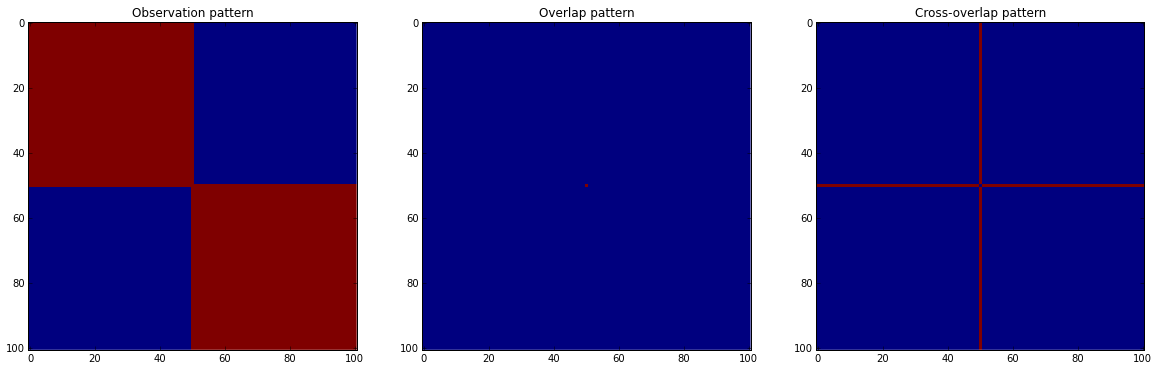

In [ ]:
p,n = 101,10
k,l = 3,3

# create subpopulations
sub_pops = (np.arange(0,p//2+1), np.arange(p//2,p))
print('sub_pops', sub_pops)
obs_idx, idx_grp, overlaps, overlap_grp, idx_overlap, Om, Ovw, Ovc = \
    ssid.get_subpop_stats(sub_pops, p, verbose=True)

for rep in range(10):


    C_true      = np.random.normal(size=(p,n))
    
    V = np.random.normal(size=(n,n))
    V /= np.sqrt(np.sum(V**2,axis=0)).reshape(1,-1)
    A_true = V.dot(np.diag(np.linspace(0.7, 0.95, n))).dot(np.linalg.inv(V))
    
    #B_true      = np.random.normal(size=(n,n))/np.sqrt(n)    
    #Pi_true     = B_true.dot(B_true.T) #np.eye(n) 
    Pi_true = sp.stats.wishart(n, np.eye(n)).rvs()/n
    B_true = np.linalg.cholesky(Pi_true)

    Qs = ssid.comp_model_covariances({'A': A_true, 'Pi': Pi_true, 'C': C_true}, k+l, Om)
    Qs_full = ssid.comp_model_covariances({'A': A_true, 'Pi': Pi_true, 'C': C_true}, k+l)


    
    A_0  = np.diag(np.random.uniform(low=0.7, high=0.8, size=n))
    B_0  = np.random.normal(size=(n,n))
    Pi_0 = B_0.dot(B_0.T)
    C_0  = np.random.normal(size=(p,n))
    pars_0 = np.hstack((A_0.reshape(n*n,),
                        B_0.reshape(n*n,),
                        C_0.reshape(p*n,)))
    H_0 = ssid.yy_Hankel_cov_mat( C_0,A_0,Pi_0,k,l,~Om)
    
    f_i, g_i = ssid.l2_setup(k,l,n,Qs,Om,idx_grp,obs_idx)
    
    print('difference in gradient to finite-differencing value:', check_grad(f_i, g_i, pars_0))    
    
    pars_est = fmin_bfgs(f_i, pars_0, fprime=g_i, gtol=1e-20)    
    A_est = pars_est[:n*n].reshape(n,n)
    B_est = pars_est[n*n:2*n*n].reshape(n,n)
    Pi_est = B_est.dot(B_est.T)
    C_est = pars_est[-p*n:].reshape(p,n)
    
    pars_init = {'A': A_0, 'C': C_0, 'Pi': Pi_0, 'B': B_0}
    pars_est  = {'A': A_est, 'C': C_est, 'Pi': Pi_est, 'B': B_est}
    pars_true = {'A': A_true, 'C': C_true, 'Pi': Pi_true, 'B': B_true}
    ssid.plot_outputs_l2_gradient_test(pars_true, pars_init, pars_est, k, l, Qs, 
                                       Qs_full, Om, Ovc, Ovw, f_i, g_i, if_flip = True)
    
    print('singular values of partial observability matrix for first subpop \n')
    _,s,_ = np.linalg.svd(ssid.observability_mat((A_true, C_true[sub_pops[0],:]), n))
    print(s)

    print('\n singular values of partial observability matrix for second subpop \n')
    _,s,_ = np.linalg.svd(ssid.observability_mat((A_true, C_true[sub_pops[1],:]), n))
    print(s)

    print('\n singular values of (noise) reachability matrix \n')
    _,s,_ = np.linalg.svd(ssid.observability_mat((A_true, B_true), n))
    print(s)

    

In [ ]:
def random_rot(dim):
    """Return a random rotation matrix, drawn from the Haar distribution
    (the only uniform distribution on SO(n)).
    The algorithm is described in the paper
    Stewart, G.W., 'The efficient generation of random orthogonal
    matrices with an application to condition estimators', SIAM Journal
    on Numerical Analysis, 17(3), pp. 403-409, 1980.
    For more information see
    http://en.wikipedia.org/wiki/Orthogonal_matrix#Randomization"""
    H = np.eye(dim)
    D = np.ones((dim,))
    for n in range(1, dim):
        x = np.random.normal(size=(dim-n+1,))
        D[n-1] = np.sign(x[0])
        x[0] -= D[n-1]*np.sqrt((x*x).sum())
        # Householder transformation

        Hx = np.eye(dim-n+1) - 2.*np.outer(x, x)/(x*x).sum()
        mat = np.eye(dim)
        mat[n-1:,n-1:] = Hx
        H = np.dot(H, mat)
    # Fix the last sign such that the determinant is 1
    D[-1] = -D.prod()
    H = (D*H.T).T
    return H